# 데이터 분석과 기계학습

## 201704235 이형주

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.impute import KNNImputer
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix ,  plot_roc_curve , classification_report , accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 개요
### 회귀 모델과 시계열 분석 모델을 통한 제주도 방문객을 예측하고자 한다.
### 미래를 예측하는것이기 때문에 시계열 분석이 적합하다. 시계열 분석에는 ARIMA 모델을 사용한다. 또한  다른 변수가 제공되었을 때, 방문자수를 예측하기 위한 회귀분석도 진행한다. 하지만 데이터수와 변수가 적어 회귀에는 적합하지 않은 데이터 세트 일 가능성이 높다. 따라서 회귀 분석을 위해 아래서 소개한 데이터를 수집하고 merge, join 하여 사용할 예정이다.

### 1. 데이터 수집

#### 2018년 1월부터 2022년 10월까지의 데이터
#### 월별 기준으로 여러 데이터를 merge 하여 데이터셋 생성
#### 검색건수: Tmap 제공 데이터 네비게이션 검색 건수 데이터
#### 지출액: BC, 신한카드 사용내역 데이터
#### 방문자수 : KT 제공 이동통신 데이터
#### covid: 통계청 제공 국내 코로나 확진자 수
#### 한국 관광 데이터랩 제공 데이터 사용
#### 변수 데이터 추가 예정
#### 관광에 영향을 줄 수 있는 데이터로는 날씨데이터, 국제유가데이터(비행기 비용) 등 -> 데이터 수집중, 기준년월 변수를 기준으로 merge 예정, 회귀 모델에 사용한다.

In [3]:
df = pd.read_csv('data.csv', encoding = 'cp949')

In [4]:
df.head()

,기준년월,광역지자체,검색건수,지출액,방문자수,covid
0,2018-01-01,제주특별자치도,691998,71336264,4434512,0
1,2018-02-01,제주특별자치도,500204,60227797,3640700,0
2,2018-03-01,제주특별자치도,709919,72959390,4402679,0
3,2018-04-01,제주특별자치도,828569,83387754,4669075,0
4,2018-05-01,제주특별자치도,879703,84132033,4700279,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기준년월    58 non-null     object
 1   광역지자체   58 non-null     object
 2   검색건수    58 non-null     int64 
 3   지출액     58 non-null     int64 
 4   방문자수    58 non-null     int64 
 5   covid   58 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 2.8+ KB


In [6]:
# 기준년월을 datetime 함수를 사용하여 시계열 데이터로 변환
df['기준년월'] = pd.to_datetime(df['기준년월'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준년월    58 non-null     datetime64[ns]
 1   광역지자체   58 non-null     object        
 2   검색건수    58 non-null     int64         
 3   지출액     58 non-null     int64         
 4   방문자수    58 non-null     int64         
 5   covid   58 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 2.8+ KB


#### datetime = 년도
#### region = 지역
#### searches = 지역 내 네비게이션 검색횟수
#### sales = 지역 내 매출액
#### visitors = 방문자수
#### covid = 코로나 확진자 수

In [8]:
# 열 변수명 변환
df.columns = ['datetime', 'region','searches','sales','visitors','covid']
df.head()

,datetime,region,searches,sales,visitors,covid
0,2018-01-01,제주특별자치도,691998,71336264,4434512,0
1,2018-02-01,제주특별자치도,500204,60227797,3640700,0
2,2018-03-01,제주특별자치도,709919,72959390,4402679,0
3,2018-04-01,제주특별자치도,828569,83387754,4669075,0
4,2018-05-01,제주특별자치도,879703,84132033,4700279,0


### 2. EDA (데이터 시각화 및 상관관계 분석)

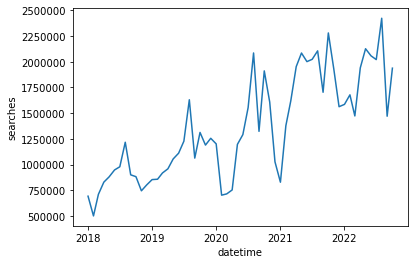

In [9]:
# lineplot을 활용하여 각 변수의 데이터 분포 확인
sns.lineplot(x='datetime', y='searches', data=df)
# y축 변수가 e릂 포함한 지수가 아닌 실수로 나오게 하는 코드
plt.ticklabel_format(axis='y',useOffset=False, style='plain')

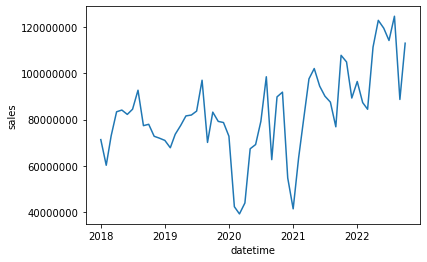

In [10]:
sns.lineplot(x='datetime', y='sales', data=df)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')

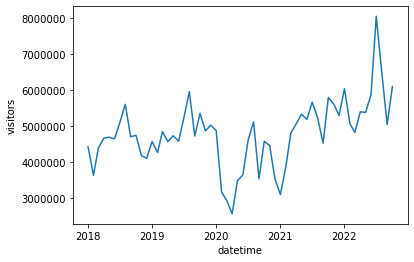

In [11]:
sns.lineplot(x='datetime', y='visitors', data=df)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')

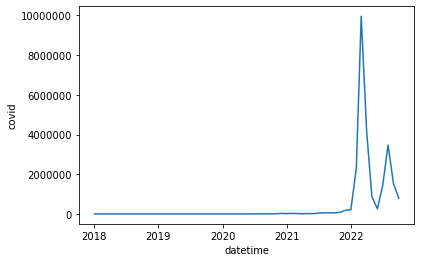

In [12]:
sns.lineplot(x='datetime', y='covid', data=df)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')

### 2020년 초반에 변수들이 급감 하는것을 확인할 수 있다. 이때 코로나가 발생하였다. 따라서 코로나가 제주도 여행객 감소에 영향을 준다는 것을 추측할 수 있다.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='visitors', ylabel='Density'>

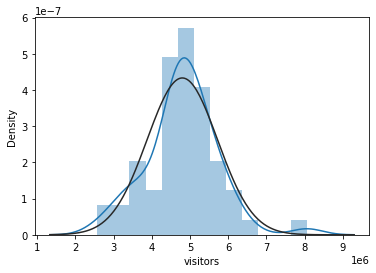

In [18]:
# 시계열 분석에 사용할 데이터인 방문객수가 정규분포를 띄고 있는지 히스토그램을 그려 확인한다. 
# 판매량이 정규분포를 띄고 있음을 확인.
from scipy import stats
from scipy.stats import norm
sns.distplot(df['visitors'],fit = norm)

((array([-2.26099814, -1.89831639, -1.68534759, -1.52930585, -1.4035404 ,
         -1.2967336 , -1.20296471, -1.11872591, -1.04175733, -0.97051207,
         -0.90388115, -0.84103998, -0.78135684, -0.72433554, -0.66957795,
         -0.61675856, -0.56560681, -0.51589434, -0.46742572, -0.42003151,
         -0.37356289, -0.32788759, -0.28288659, -0.23845156, -0.19448263,
         -0.15088668, -0.10757577, -0.06446581, -0.02147538,  0.02147538,
          0.06446581,  0.10757577,  0.15088668,  0.19448263,  0.23845156,
          0.28288659,  0.32788759,  0.37356289,  0.42003151,  0.46742572,
          0.51589434,  0.56560681,  0.61675856,  0.66957795,  0.72433554,
          0.78135684,  0.84103998,  0.90388115,  0.97051207,  1.04175733,
          1.11872591,  1.20296471,  1.2967336 ,  1.4035404 ,  1.52930585,
          1.68534759,  1.89831639,  2.26099814]),
  array([2569992, 2948705, 3108770, 3172778, 3487464, 3539240, 3547286,
         3640700, 3651489, 3882244, 4114478, 4188600, 4275507, 4

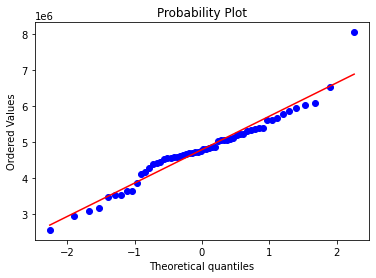

In [19]:
# Q-Q plot을 통하여 정규분포를 띄고 있는것을 확인
stats.probplot(df['visitors'], plot=plt)

<AxesSubplot:>

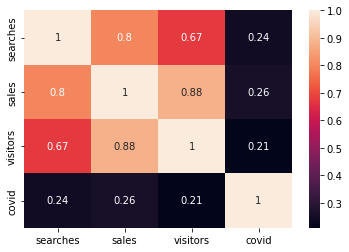

In [20]:
# 변수들간의 상관관계를 히트맵으로 표현
sns.heatmap(df.corr(), annot = True)

### 3. 데이터 모델링(시계열 모델)
### 시계열 모델에서는 미래의 방문객을 예측하는 것이기 때문에 datetime 변수와 visitors 변수만을 사용한다
### ARIMA 모델과 Keras의 LSTM 모델 사용 , 진행 예정

In [20]:
df1 = df[['datetime','visitors']]
data = df1.set_index('datetime')
data.head()

,visitors
datetime,
2018-01-01,4434512
2018-02-01,3640700
2018-03-01,4402679
2018-04-01,4669075
2018-05-01,4700279


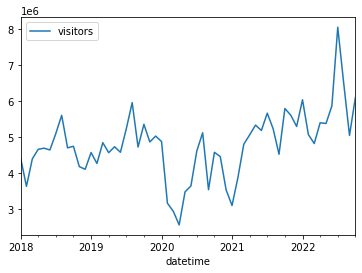

In [21]:
fig = data.plot()

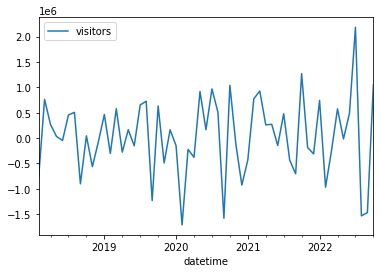

In [24]:
diff_1=data.diff(periods=1).iloc[1:]
diff_1.plot()
plt.show()

### 4. 데이터 모델링 (회귀 분석)

### train_test_split 함수를 사용하여 학습용 평가용 데이터를 7:3으로 나눈다.

### MinMaxScaler 를 사용하여 데이터를 정규화한다.
### pipeline 을 사용하여 캡슐화 진행
### 회귀에서 사용할 모델은 LinearRegression, Randomforest, gradientBoostingRegressor, SVM 기법을 사용
### svm 모델과 하이퍼 파라미터 튜닝은 진행 예정


In [21]:
# y 방문자수를 종속변수, 나머지 변수들을 독립변수로 train_test_split 진행
X = df[["searches", "sales", "covid"]]
y = df["visitors"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 2022)

In [22]:
# 선형회귀 모델 ,데이터 수가 너무적어 난수에 따라 과적합 발생 => 적합하지 않은 회귀모형이라 판단.

lr = LinearRegression()
lr_pipe = make_pipeline(MinMaxScaler(), LinearRegression())
lr_pipe.fit(X_train, y_train)

print("학습용 데이터 세트 정확도 점수: {:.3f}".format(lr_pipe.score(X_train, y_train)))
print("평가용 데이터 세트 정확도 점수: {:.3f}".format(lr_pipe.score(X_test, y_test)))

학습용 데이터 세트 정확도 점수: 0.710
평가용 데이터 세트 정확도 점수: 0.933


In [23]:
# 랜덤 포레스트 모델, 정확도가 좋게 나온다.
rf = RandomForestRegressor()
rf_pipe = make_pipeline(MinMaxScaler(), RandomForestRegressor())
rf_pipe.fit(X_train, y_train.values.ravel())

print("학습용 데이터 세트 정확도 점수: {:.3f}".format(rf_pipe.score(X_train, y_train)))
print("평가용 데이터 세트 정확도 점수: {:.3f}".format(rf_pipe.score(X_test, y_test)))

학습용 데이터 세트 정확도 점수: 0.937
평가용 데이터 세트 정확도 점수: 0.862


In [24]:
# 그레디언트 부스팅 회귀
gbrt = make_pipeline(MinMaxScaler(), GradientBoostingRegressor(random_state = 1))
gbrt.fit(X_train, y_train)

print("학습용 데이터 세트 정확도 점수: {:.3f}".format(gbrt.score(X_train, y_train)))
print("평가용 데이터 세트 정확도 점수: {:.3f}".format(gbrt.score(X_test, y_test)))

학습용 데이터 세트 정확도 점수: 0.999
평가용 데이터 세트 정확도 점수: 0.868


In [25]:
# svm
import sklearn.svm as svm
svm_clf =svm.SVC(kernel = 'linear')

### 5. 모델 평가
### MAE, MSE, RMSE, R2 Score 등을 활용하여 성능을 평가 한다.